In [1]:
%matplotlib inline
#%% NumPyの読み込み
import numpy as np
#   NumPyのLinalgモジュールの読み込み
import numpy.linalg as lin
#   SciPyのoptimizeモジュールの読み込み
import scipy.optimize as opt
#   CVXPYの読み込み
import cvxpy as cvx
#   Pandasの読み込み
import pandas as pd
#   MatplotlibのPyplotモジュールの読み込み
import matplotlib.pyplot as plt
#   日本語フォントの設定
from matplotlib.font_manager import FontProperties
import sys
if sys.platform.startswith('win'):
    FontPath = 'C:\\Windows\\Fonts\\meiryo.ttc'
elif sys.platform.startswith('darwin'):
    FontPath = '/System/Library/Fonts/ヒラギノ角ゴシック W4.ttc'
elif sys.platform.startswith('linux'):
    FontPath = '/usr/share/fonts/truetype/takao-gothic/TakaoPGothic.ttf'
jpfont = FontProperties(fname=FontPath)

In [2]:
#%% 収益率データの読み込み
R = pd.read_csv('asset_return_data.csv', index_col=0)
T = R.shape[0]
N = R.shape[1]
Mu = R.mean().values

In [3]:
#%% 平均絶対偏差最小化問題の設定
Return_Dev = (R - Mu).values / T
Weight = cvx.Variable(N)
Deviation = cvx.Variable(T)
Target_Return = cvx.Parameter(nonneg=True)
Risk_AD = cvx.norm(Deviation, 1)
Opt_Portfolio = cvx.Problem(cvx.Minimize(Risk_AD),
                            [Return_Dev * Weight == Deviation,
                             Weight.T * Mu == Target_Return,
                             cvx.sum(Weight) == 1.0,
                             Weight >= 0.0])

In [4]:
#%% 最小平均絶対偏差フロンティアの計算
V_Target = np.linspace(Mu.min(), Mu.max(), num=250)
V_Risk = np.zeros(V_Target.shape)
for idx, Target_Return.value in enumerate(V_Target):
    Opt_Portfolio.solve(solver=cvx.ECOS)
    V_Risk[idx] = Risk_AD.value

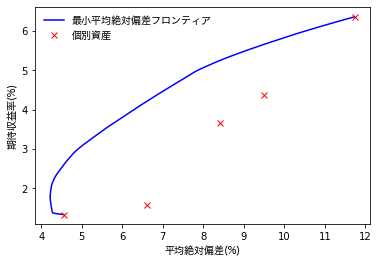

In [5]:
#%% 最小平均絶対偏差フロンティアのグラフの作成
fig1 = plt.figure(num=1, facecolor='w')
plt.plot(V_Risk, V_Target, 'b-')
plt.plot((R - Mu).abs().mean().values, Mu, 'rx')
plt.legend([u'最小平均絶対偏差フロンティア', u'個別資産'],
           loc='best', frameon=False, prop=jpfont)
plt.xlabel(u'平均絶対偏差(%)', fontproperties=jpfont)
plt.ylabel(u'期待収益率(%)', fontproperties=jpfont)
plt.show()

In [6]:
#%% 下方半分散最小化問題の設定
Return_Dev = (R - Mu).values / np.sqrt(T)
Weight = cvx.Variable(N)
Deviation = cvx.Variable(T)
Target_Return = cvx.Parameter(nonneg=True)
Risk_Semivariance = cvx.sum_squares(Deviation)
Opt_Portfolio = cvx.Problem(cvx.Minimize(Risk_Semivariance),
                            [Weight.T*Mu == Target_Return,
                             cvx.sum(Weight) == 1.0,
                             Weight >= 0.0,
                             Deviation >= 0.0,
                             Return_Dev*Weight + Deviation >= 0.0])

In [7]:
#%% 最小下方半分散フロンティアの計算
V_Target = np.linspace(Mu.min(), Mu.max(), num=250)
V_Risk = np.zeros(V_Target.shape)
for idx, Target_Return.value in enumerate(V_Target):
    Opt_Portfolio.solve(solver=cvx.ECOS)
    V_Risk[idx] = np.sqrt(Risk_Semivariance.value)

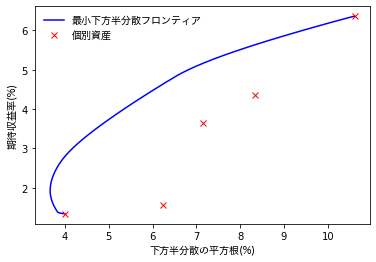

In [8]:
#%% 最小下方半分散フロンティアのグラフの作成
fig2 = plt.figure(num=2, facecolor='w')
plt.plot(V_Risk, V_Target, 'b-')
plt.plot(np.sqrt(((R[R <= Mu] - Mu) ** 2).sum().values / T), Mu, 'rx')
plt.legend([u'最小下方半分散フロンティア', u'個別資産'],
           loc='best', frameon=False, prop=jpfont)
plt.xlabel(u'下方半分散の平方根(%)', fontproperties=jpfont)
plt.ylabel(u'期待収益率(%)', fontproperties=jpfont)
plt.show()

In [9]:
#%% 期待ショートフォール最小化問題の設定
Return = R.values / T
Weight = cvx.Variable(N)
Deviation = cvx.Variable(T)
VaR = cvx.Variable()
Alpha = cvx.Parameter(nonneg=True)
Target_Return = cvx.Parameter(nonneg=True)
Risk_ES = cvx.sum(Deviation)/Alpha - VaR
Opt_Portfolio = cvx.Problem(cvx.Minimize(Risk_ES),
                            [Weight.T*Mu == Target_Return,
                             cvx.sum(Weight) == 1.0,
                             Weight >= 0.0,
                             Deviation >= 0.0,
                             Return*Weight - VaR/T + Deviation >= 0.0])

In [10]:
#%% 最小ESフロンティアの計算
V_Alpha = np.array([0.05, 0.10, 0.25, 0.50])
V_Target = np.linspace(Mu.min(), Mu.max(), num=250)
V_Risk = np.zeros((V_Target.shape[0], V_Alpha.shape[0]))
for idx_col, Alpha.value in enumerate(V_Alpha):
    Alpha.value = V_Alpha[idx_col]
    for idx_row, Target_Return.value in enumerate(V_Target):
        Opt_Portfolio.solve(solver=cvx.ECOS)
        V_Risk[idx_row, idx_col] = Risk_ES.value

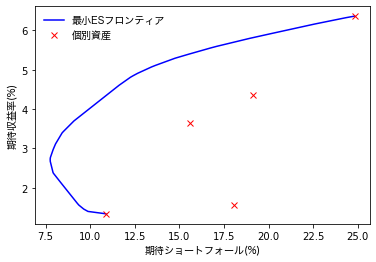

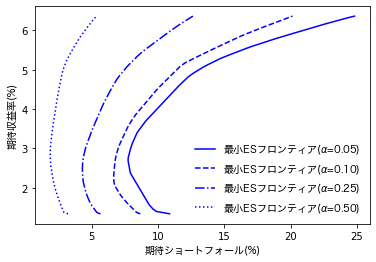

In [11]:
#%% 最小ESフロンティアのグラフの作成
fig3 = plt.figure(num=3, facecolor='w')
plt.plot(V_Risk[:, 0], V_Target, 'b-')
plt.plot((-R[R <= R.quantile(V_Alpha[0])]).mean().values, Mu, 'rx')
plt.legend([u'最小ESフロンティア', u'個別資産'],
           loc='best', frameon=False, prop=jpfont)
plt.xlabel(u'期待ショートフォール(%)', fontproperties=jpfont)
plt.ylabel(u'期待収益率(%)', fontproperties=jpfont)
fig4 = plt.figure(num=4, facecolor='w')
LineTypes = ['solid', 'dashed', 'dashdot', 'dotted']
for idx, Alpha.value in enumerate(V_Alpha):
    plt.plot(V_Risk[:, idx], V_Target, color='b', linestyle=LineTypes[idx])
plt.legend([u'最小ESフロンティア($\\alpha$={0:4.2f})'.format(a) for a in V_Alpha],
           loc='best', frameon=False, prop=jpfont)
plt.xlabel(u'期待ショートフォール(%)', fontproperties=jpfont)
plt.ylabel(u'期待収益率(%)', fontproperties=jpfont)
plt.show()

In [12]:
#%% リスク寄与度の平準化によるポートフォリオ選択
Mu = np.array([1.0, 3.0, 1.5, 6.0, 4.5])
Stdev = np.array([5.0, 10.0, 7.5, 15.0, 11.0])
CorrMatrix = np.array([[1.00, 0.25, 0.18, 0.10, 0.25],
                       [0.25, 1.00, 0.36, 0.20, 0.20],
                       [0.18, 0.36, 1.00, 0.25, 0.36],
                       [0.10, 0.20, 0.25, 1.00, 0.45],
                       [0.25, 0.20, 0.36, 0.45, 1.00]])
Sigma = np.diag(Stdev) @ CorrMatrix @ np.diag(Stdev)
iota = np.ones(Mu.shape)
inv_Sigma = lin.inv(Sigma)
Weight_1N = np.tile(1.0/Mu.shape[0], Mu.shape[0])
Weight_MV = inv_Sigma @ iota / (iota @ inv_Sigma @ iota)
Weight_MD = inv_Sigma @ Stdev / (iota @ inv_Sigma @ Stdev)
F = lambda v, Sigma: np.hstack((Sigma @ v[:-1] - v[-1]/v[:-1], v[:-1].sum() - 1.0))
Weight_RP = opt.root(F, np.hstack((Weight_1N, 0.0)), args=Sigma).x[:-1]
np.set_printoptions(formatter={'float': '{:7.2f}'.format})
print(np.vstack((Weight_1N, Weight_MV, Weight_RP, Weight_MD))*100)

[[  20.00   20.00   20.00   20.00   20.00]
 [  69.77    3.79   23.33    2.98    0.14]
 [  36.52   16.78   21.39   11.35   13.96]
 [  42.81   16.10   19.22   12.61    9.26]]
